# Machine Learning - Practical 2: Generative and Discriminative Models

Import Libraries

In [5]:
%matplotlib inline

import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
import pickle as cp

In [6]:
class NBC:
    # feature_types: 'b' -> binary, 'r' -> real
    def __init__(self, feature_types, num_classes):
        self.features = feature_types
        self.num_classes = num_classes
        self.separated_means = []
        self.separated_std = []
        self.frequency = []
        self.bernoulli_p = []

    def fit(self, Xtrain, ytrain):
        separated = self.separateByClass(Xtrain,ytrain)

        if self.features == 'r':
            for i in range(len(separated)):
                self.frequency.append(separated[i].shape[0] / Xtrain.shape[0])
                self.separated_means.append(self.get_feature_means(separated[i]))
                self.separated_std.append(self.get_feature_std_dev(
                    separated[i], self.separated_means[-1]))
        else:
            for i in range(len(separated)):
                self.frequency.append(separated[i].shape[0] / Xtrain.shape[0])
                curr_class_frequencies = [0 for _ in range(Xtrain.shape[1])]
                for j in range(len(separated[i])):
                    curr_class_frequencies += separated[i][j]
                
                self.bernoulli_p.append(curr_class_frequencies / separated[i].shape[0])

    def predict(self, Xtest):
        N,D = Xtest.shape

        predicted_classes = []
        for curr_data in range(N):
            classes_prob = [1 for _ in range(self.num_classes)]
            for curr_class in range(self.num_classes):
                    for curr_attr in range(D):
                        if self.features == 'r':
                            classes_prob[curr_class] *= self.calculateGaussian(
                                Xtest[curr_data][curr_attr], 
                                self.separated_means[curr_class][curr_attr], 
                                self.separated_std[curr_class][curr_attr])
                        else:
                            classes_prob[curr_class] *= self.calculateBernoulli(
                                Xtest[curr_data][curr_attr], 
                                self.bernoulli_p[curr_class][curr_attr])

                    classes_prob[curr_class] *= self.frequency[curr_class]                        

            predicted_classes.append(classes_prob.index(max(classes_prob)))

        return predicted_classes
        
    def separateByClass(self, X, y):
        separated = [[] for _ in range(self.num_classes)]
        for i in range(len(y)):
            separated[int(y[i])].append(X[i])

        for i in range(len(separated)):
            if(len(separated[i]) > 0):
                separated[i] = np.vstack(separated[i])
            else:
                separated[i] = np.zeros(shape=(1,X.shape[1]))

        return separated

    def get_feature_means(self, X):
        N, D = X.shape
        feature_means = []
        for col in range(D):
            feature_means.append(float(0))
            for row in range(N):
                feature_means[-1] += X[row][col]
            feature_means[-1] = feature_means[-1] / N
        return feature_means

    def get_feature_std_dev(self, X, means):
        N, D = X.shape
        feature_std_dev = []
        for col in range(D):
            feature_std_dev.append(float(0))
            for row in range(N):
                feature_std_dev[-1] += (X[row][col] - means[col])**2
            feature_std_dev[-1] = max(np.sqrt(feature_std_dev[-1] / N), 1e-6)
        return feature_std_dev

    def calculateGaussianProbability(self, x, mean, stdev):
        exponent = math.exp(-math.pow((x - mean) / stdev, 2) / 2)
        return(1 / (math.sqrt(2*math.pi) * stdev)) * exponent

    def calculateBernoulliProbability(self, k, p):
        if k == 0:
            return 1 - p
        return p

# Handin 1

In the lectures, we only formulated the negative log-likelihood for logistic regression without adding any regularization term. As per the formulation used in the lectures, if you wanted to add wTwwTw as a regularization to the negative log-likelihood of observing the data, and set λ=0.1λ=0.1, what value of C would you set in the sklearn implementation?

C is the inverse of the regularization. We then have to specify C = 5

# Handin 2

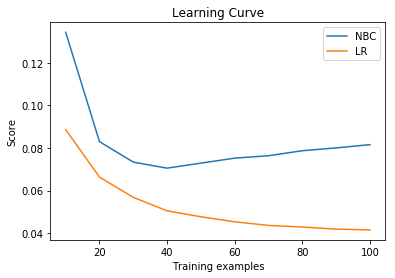

In [12]:
iris = load_iris()
#X,y = iris['data'], iris['target']
X, y = cp.load(open('voting.pickle', 'rb'))

N,D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]

def learning_curve (title, X, y, min_perc, max_perc, step):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    N, D = X.shape
    Ntrain = int(0.8 * N)
    
    errors_nbc = [0 for _ in range(10)]
    errors_linear = [0 for _ in range(10)]

    num_iterations = 1000
    
    for _ in range(num_iterations):
        shuffler = np.random.permutation(N)
        Xtrain = X[shuffler[:Ntrain]]
        ytrain = y[shuffler[:Ntrain]]
        Xtest = X[shuffler[Ntrain:]]
        ytest = y[shuffler[Ntrain:]]

        pos = 0
        for i in range (min_perc, max_perc + 1, step):
            X_train = Xtrain[:int(len(Xtrain) / 100 * i)]
            y_train = ytrain[:int(len(ytrain) / 100 * i)]
            
            # Naive Bayes
            nbc = NBC('b',2)
            nbc.fit(X_train, y_train)
            yhat = nbc.predict(Xtest)
            mean_nbc = 1 - np.mean(yhat == ytest)

            # Logistic
            clf = LogisticRegression(random_state=0, solver='newton-cg',
                                     multi_class='multinomial').fit(
                                     X_train, y_train)
            mean_linear = 1 - clf.score(Xtest,ytest)
            
            errors_nbc[pos] += (mean_nbc / num_iterations)
            errors_linear[pos] += (mean_linear/ num_iterations)
            pos += 1

    plt.plot(np.linspace(10,100, num=10), errors_nbc, label='NBC')
    plt.plot(np.linspace(10,100, num=10), errors_linear, label='LR')
    plt.legend()
    plt.show()

learning_curve('Learning Curve', X, y, 10, 100, 10)

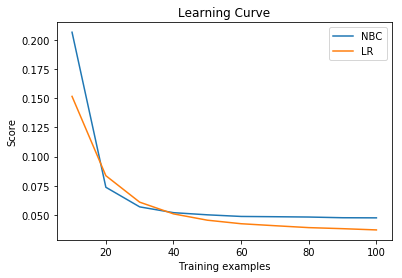

In [15]:
iris = load_iris()
X,y = iris['data'], iris['target']

N,D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]

def learning_curve (title, X, y, min_perc, max_perc, step):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    N, D = X.shape
    Ntrain = int(0.8 * N)
    
    errors_nbc = [0 for _ in range(10)]
    errors_linear = [0 for _ in range(10)]

    num_iterations = 1000
    
    for _ in range(num_iterations):
        shuffler = np.random.permutation(N)
        Xtrain = X[shuffler[:Ntrain]]
        ytrain = y[shuffler[:Ntrain]]
        Xtest = X[shuffler[Ntrain:]]
        ytest = y[shuffler[Ntrain:]]

        pos = 0
        for i in range (min_perc, max_perc + 1, step):
            X_train = Xtrain[:int(len(Xtrain) / 100 * i)]
            y_train = ytrain[:int(len(ytrain) / 100 * i)]
            
            # Naive Bayes
            nbc = NBC('r',3)
            nbc.fit(X_train, y_train)
            yhat = nbc.predict(Xtest)
            mean_nbc = 1 - np.mean(yhat == ytest)

            # Logistic Regression
            clf = LogisticRegression(random_state=0, solver='newton-cg',
                                     multi_class='multinomial').fit(X_train, y_train)
            mean_linear = 1 - clf.score(Xtest,ytest)
            
            errors_nbc[pos] += (mean_nbc / num_iterations)
            errors_linear[pos] += (mean_linear/ num_iterations)
            pos += 1

    plt.plot(np.linspace(10,100, num=10), errors_nbc, label='NBC')
    plt.plot(np.linspace(10,100, num=10), errors_linear, label='LR')
    plt.legend()
    plt.show()

learning_curve('Learning Curve', X, y, 10, 100, 10)